# **DIVE INTO CODE COURSE**
## **Graduation Assignment**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

## Introduction

The graduation assignment was based on one of the challenges from the Vietnamese competition **Zalo AI Challenge**. The description of the challenge is described as follows:

> During the Covid-19 outbreak, the Vietnamese government pushed the "5K" public health safety message. In the message, masking and keeping a safe distance are two key rules that have been shown to be extremely successful in preventing people from contracting or spreading the virus. Enforcing these principles on a large scale is where technology may help. In this challenge, you will create algorithm to detect whether or not a person or group of individuals in a picture adhere to the "mask" and "distance" standards.

**Basic rules**
We are given the dataset contains images of people either wearing mask or not and they are standing either close of far from each other. Our mission is to predict whether the formation of these people adhere the 5k standard.

The 5k standard is also based on the two conditions, mask (0 == not wearing, 1 == wearing) and distancing (0 == too close, 1 == far enough). People that adhere the 5k standard will not likely to expose the virus to each other in case they did caught it before, and it is to prevent the spread of the COVID-19 pandamic through people interactions.



---



In [2]:
!pip install wandb

In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
from tensorflow.data import AUTOTUNE
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, RandomZoom, RandomFlip, InputLayer
from tensorflow.keras.layers.experimental.preprocessing import RandomWidth
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow_hub as hub

from PIL import Image

tf.config.run_functions_eagerly(True)

tf.data.experimental.enable_debug_mode()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Num GPUs Available:  1
Tensorflow version: 2.6.2
Keras version: 2.6.0


2022-02-19 18:43:37.243250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 18:43:37.342340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 18:43:37.343026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
!nvidia-smi # For GPU runtime

Sat Feb 19 18:43:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Recreate the pipeline**

Since making the process of detecting mask and distancing to be seperated procedures, evaluate new models or changing hyperparameters would be exhausted. In this section, I manage to create the pipeline that can be run once to train, predict and monitor the metrics. 

But before heading to that part, we can re-examine our problem to find a better way for a better results. One problem still remains is that the dataset contain so many missing values, and it is in fact can affect our model predictions, hence getting less accuracy.

Missing values

In [5]:
# data_path = '/content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data'
data_path = "/kaggle/input/zalo-ai-challenge-2021-5k-compliance/5k-compliance/train/"
model_path = "/kaggle/working"
img_dir = os.path.join(data_path, 'images')

In [4]:
meta = pd.read_csv(data_path + 'train_meta.csv')

<AxesSubplot:>

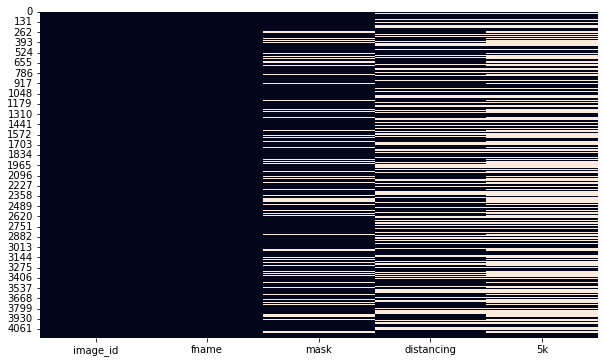

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(meta.isnull(), cbar=False)

In [6]:
print('Num. missing mask',\
      len(meta[meta['mask'].isna()]))

print('Num. missing distancing',\
      len(meta[meta['distancing'].isna()]))

print('Num. missing 5k',\
      len(meta[meta['5k'].isna()]))

print('Num. missing mask and distancing:',\
      len(meta[(meta['mask'].isna()) & (meta['distancing'].isna())]))

print('Num. missing mask and 5k:',\
      len(meta[(meta['mask'].isna()) & (meta['5k'].isna())]))

print('Num. missing distancing and 5k:',\
      len(meta[(meta['distancing'].isna()) & (meta['5k'].isna())]))

print('Num. missing all three attributes:',\
      len(meta[(meta['mask'].isna()) & (meta['distancing'].isna()) & (meta['5k'].isna())]))

Num. missing mask 734
Num. missing distancing 1273
Num. missing 5k 2007
Num. missing mask and distancing: 0
Num. missing mask and 5k: 734
Num. missing distancing and 5k: 1273
Num. missing all three attributes: 0


Apparently, the missing values are occurs as either missing one of three attribute, or a pair of attributes respectively (except for mask and distancing). None of row missing all three attributes.

To get the 5k value, we should have know the mask and distancing value first. Luckily, none of row miss these two variables. Therefore, we can fill the missing values with our own logics (not all the cases).

The original rule for 5k evaluation can be described as follow:
```
5k = 1 if (mask == 1 and distancing == 1) else 0
```

Base on this, we can design a pipeline that can fill out the missing values and produce better results:

> 1. Model mask detection -> Use to predict the missing mask values -> From there continue to fill the missing distancing values
```
if (mask == 1) and (5k == 1):
    distancing = 1
elif (mask == 1) and (5k == 0):
    distancing = 0
elif (mask == 0) and (5k == 0)
    distancing = 0
```
In case the mask is 0, we can skip it since `mask == 0 and 5k == 0` is the only case we can intepret with and in that case, I have run the code: 
`meta[(meta['mask'] == 0) & (meta['5k'] == 0) & (meta['distancing'].isna())]` and it return nothing. So it is safe to assume this part does not miss any values and is skippable.

> 2. Model distancing -> Use to predict the missing 5k values
```
if (distancing == 1) and (mask == 1)
    5k == 1
elif (distancing == 0) or (mask == 0)
    5k == 0
```

> 3. Model 5k -> Use to predict the final output 5k

In conclusion, the difference between the previous section and this section is that we will make three models instead of two. This is doable as we are going to fill the missing 5k values, thus we can use this attribute for our final prediction.

#### Define resources

In [6]:
!wandb login 88c91a7dc6dd5574f423e38f852c6fe640a7fcd0

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
wandb.init(project="diveintocode-grad-5k", entity="atien228")

wandb: Currently logged in as: atien228 (use `wandb login --relogin` to force relogin)


#### Hyparameters

In [8]:
standard = 'mask' #@param ['mask', 'distancing']
SEED = 42 #@param {type:'integer'}

wandb.config = {
  "learning_rate": 0.001, 
  "epochs": 13,
  "batch_size": 20,
  "momentum": 0.5,
  "smoothing": 0.1
}

In [9]:
# Model configuration
os.environ["TFHUB_CACHE_DIR"] = model_path + "/tmp/model"
model_name = "efficientnetv2-b3-21k-ft1k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']
trainable = True
loss_function = sparse_categorical_crossentropy
optimizer = SGD(learning_rate=wandb.config['learning_rate'],
                momentum=wandb.config['momentum']
               )
verbose = 1
num_folds = 2 # Testing

#### FiveKCompliance class

In [10]:
class FiveKCompliance():
    def __init__(self, model_name, seed, config, data_path): 
        self.seed = seed
        self.lr = config['learning_rate']
        self.epochs = config['epochs']
        self.batch_size = config['batch_size']
        self.momentum = config['momentum']
        self.smoothing = config['smoothing']
        self.n_channels = 3
        self.buffer_size = 1024
        self.data_path = data_path
        self.model_name = model_name

    # ------- Functions for data-set processing --------------- #
    def create_dataset(self, df_train, df_val):

        # Create tf.data.Dataset from the tuple of image path and labels
        ds_train = tf.data.Dataset.from_tensor_slices((list(df_train[0]), list(df_train[1])))

        # Configure with W&B settings
        ds_train = (ds_train
                    .shuffle(buffer_size=self.buffer_size)
                    .map(self.load_img, num_parallel_calls=AUTOTUNE)
                    .batch(self.batch_size)
                    .cache()
                    .prefetch(AUTOTUNE))
        
        if df_val is not None:
            ds_val = tf.data.Dataset.from_tensor_slices((list(df_val[0]), list(df_val[1])))

            # Configure with W&B settings
            ds_val = (ds_val
                    .shuffle(buffer_size=self.buffer_size)
                    .map(self.load_img, num_parallel_calls=AUTOTUNE)
                    .batch(self.batch_size)
                    .cache()
                    .prefetch(AUTOTUNE))
        
        return ds_train, ds_val


    def preprocessing_data(self, meta, standard):
        dataset = []
        label = []

        for idx, row in meta.iterrows():
            if pd.notna(row[standard]):
                dataset.append(os.path.join(img_dir, row['fname'])) # Mask or distancing
                label.append(row[standard])

        df_train, df_val, label_train, label_val = train_test_split(dataset, label, test_size=0.2, random_state=SEED, shuffle=True)

        return df_train, df_val, label_train, label_val


    def load_img(self, path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.img_size)
        onehot_label = tf.argmax(label == [0.0, 1.0])

        return img, onehot_label

    # ------- Functions for modeling --------------- #
    def get_hub_url_and_isize(self, model_name):

        model_handle_map = {
            "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
            "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
            "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
            "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
            "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
            "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
            "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
            "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
            "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
            "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
            "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
            "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
            "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
            "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
            "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
            "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
            "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
            "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
            "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
            "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
            "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
            "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
            "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
            "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
            "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
            "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
            "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
            "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
            "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
            "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
            "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
            "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
            "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
            "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
            "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
            "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
            "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
            "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
            "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
            "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
            "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
            "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
            "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
            "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
            "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
            "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
            "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
            "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
            "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
            "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
        }

        model_image_size_map = {
            "efficientnetv2-s": 384,
            "efficientnetv2-m": 480,
            "efficientnetv2-l": 480,
            "efficientnetv2-b0": 224,
            "efficientnetv2-b1": 240,
            "efficientnetv2-b2": 260,
            "efficientnetv2-b3": 300,
            "efficientnetv2-s-21k": 384,
            "efficientnetv2-m-21k": 480,
            "efficientnetv2-l-21k": 480,
            "efficientnetv2-xl-21k": 512,
            "efficientnetv2-b0-21k": 224,
            "efficientnetv2-b1-21k": 240,
            "efficientnetv2-b2-21k": 260,
            "efficientnetv2-b3-21k": 300,
            "efficientnetv2-s-21k-ft1k": 384,
            "efficientnetv2-m-21k-ft1k": 480,
            "efficientnetv2-l-21k-ft1k": 480,
            "efficientnetv2-xl-21k-ft1k": 512,
            "efficientnetv2-b0-21k-ft1k": 224,
            "efficientnetv2-b1-21k-ft1k": 240,
            "efficientnetv2-b2-21k-ft1k": 260,
            "efficientnetv2-b3-21k-ft1k": 300, 
            "efficientnet_b0": 224,
            "efficientnet_b1": 240,
            "efficientnet_b2": 260,
            "efficientnet_b3": 300,
            "efficientnet_b4": 380,
            "efficientnet_b5": 456,
            "efficientnet_b6": 528,
            "efficientnet_b7": 600,
            "inception_v3": 299,
            "inception_resnet_v2": 299,
            "nasnet_large": 331,
            "pnasnet_large": 331,
        }

        model_type = model_handle_map.get(model_name)
        pixels = model_image_size_map.get(model_name)

        print(f"Selected model: {model_name} : {model_type}")

        IMAGE_SIZE = (pixels, pixels)
        print(f"Input size {IMAGE_SIZE}")

        return model_type, IMAGE_SIZE, pixels


    def modeling(self, model_url, img_size, pixels, loss_function, optimizer, verbose, trainable):
        IMG_HEIGHT = IMG_WIDTH = pixels

        # Data augmentation layer for image
        data_augmentation = Sequential([
            InputLayer(input_shape=[IMG_HEIGHT, IMG_WIDTH, self.n_channels]),
            RandomFlip("horizontal_and_vertical", seed=self.seed),
            RandomZoom(0.1, seed=self.seed),
            #RandomWidth(0.1, seed=self.seed),
        ])

        EfficientNetV2 = hub.KerasLayer(model_url, trainable=trainable) # Trainable: Fine tuning

        self.model = Sequential([
            data_augmentation,
            EfficientNetV2,
            Dropout(rate=0.2, seed=self.seed),
            Dense(units=2, # Binary classifcation
                  activation='softmax',
                  kernel_regularizer=tf.keras.regularizers.l2(0.0001))
        ])

        self.model.build((None,) + img_size + (self.n_channels,)) # (IMG_SIZE, IMG_SIZE, 3)
        self.model.summary()

        self.model.compile(optimizer=optimizer,
                           loss=loss_function,
                           metrics=['accuracy', self.f1])

    
    def train(self, meta, num_folds, loss_function, optimizer, verbose, trainable, standard, model_path):
        self.model_url, self.img_size, self.pixels = self.get_hub_url_and_isize(self.model_name)

        df_train, df_test, label_train, label_test = self.preprocessing_data(meta, standard)

        df_train = tuple(zip(df_train, label_train))
        df_test = tuple(zip(df_test, label_test))

        df_train = tuple(zip(*df_train))
        df_test = tuple(zip(*df_test))

        ds_train, ds_test = self.create_dataset(df_train, df_test)

        ds_train = ds_train.shuffle(10)
        ds_val = ds_train.take(int(0.25*(len(ds_train)))) # Train/validation set split (80/20)
        ds_train = ds_train.skip(int(0.25*(len(ds_train))))

        self.modeling(self.model_url, self.img_size, self.pixels, loss_function, optimizer, verbose, trainable)

        history = self.model.fit(ds_train,
                                validation_data=ds_val,
                                epochs=self.epochs,
                                callbacks=[WandbCallback()],
                                verbose=verbose)
        
        print('------------------------------Evaluation--------------------------------')
        scores = self.model.evaluate(ds_test, verbose=verbose)
 
        # Save model and weights
        self.model.save(model_path + f'/{standard}.h5')
        self.model.save_weights(model_path + f'/{standard}_weight.h5')


    @tf.autograph.experimental.do_not_convert
    def f1(self, y_true, y_pred):
        return f1_score(y_true,
                        tf.math.argmax(y_pred, 1))

Train the model

In [10]:
fivek = FiveKCompliance(model_name=model_name, seed=SEED, config=wandb.config, data_path=data_path)

In [ ]:
fivek.train(meta=meta,
            num_folds=num_folds,
            loss_function=loss_function,
            optimizer=optimizer,
            verbose=verbose,
            trainable=trainable,
            standard=standard,
            model_path=model_path + '/model_saved')

Load mask model and pseudo labeling distance value

In [11]:
# Redefine the f1 function for keras model dependencies
@tf.autograph.experimental.do_not_convert
def f1(self, y_true, y_pred):
    return f1_score(y_true,
                    tf.math.argmax(y_pred, 1))

In [12]:
model_url, img_size, _ = fivek.get_hub_url_and_isize(model_name)

Selected model: efficientnetv2-b3-21k-ft1k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2
Input size (300, 300)


In [13]:
dependencies = {
    'f1': f1,
    'KerasLayer': hub.KerasLayer(model_url, trainable=trainable)
}
model_mask = keras.models.load_model(f'../input/model-saved/{standard}.h5', custom_objects=dependencies)
model_mask.summary()

2022-02-19 17:31:22.479977: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 17:31:22.481031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 17:31:22.481846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 17:31:22.482478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1536)              12930622  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 12,933,696
Trainable params: 12,824,480
Non-trainable params: 109,216
_________________________________________________________________


In [14]:
pseudo_lbl_img_name = meta['fname']
pseudo_lbl_img_path = img_dir

In [16]:
def predict_custom(model, meta, img_path, img_size, case):
    
    no_img_filled = 0
    
    for i, row in tqdm(enumerate(meta.itertuples(), 0)):
        if pd.isna(getattr(row, case)):
            image = tf.io.read_file(img_path + f'/{row.fname}')
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, img_size)

            prediction_scores = model.predict(np.expand_dims(image, axis=0))
                                        
            meta.at[i, case] = np.argmax(prediction_scores)
            
            no_img_filled += 1

    print(f"Predicted {no_img_filled} images.")
                                    
    return meta

In [17]:
case = 'mask'
new_meta_mask = predict_custom(model_mask, meta, img_dir, img_size, case)

0it [00:00, ?it/s]2022-02-19 17:31:52.646357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-19 17:31:54.429101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
4175it [01:04, 64.97it/s] 

Predicted 734 images.


In [18]:
new_meta_mask_copy = new_meta_mask.copy()

```
Part 1
if (mask == 1) and (5k == 1):
    distancing = 1
elif (mask == 1) and (5k == 0):
    distancing = 0
```

In [126]:
def pseudo_labeling(mask, distancing, fivek, label):
    
    new_distancing = distancing
    new_fivek = fivek
    
    if label == 'distancing':
        if fivek == 0 and mask == 1 and math.isnan(distancing):
            new_distancing = 1.0
        elif fivek == 1 and mask == 1 and math.isnan(distancing):
            new_distancing = 0.0
        
        return new_distancing
            
    elif label == '5k':
        if distancing == 1 and mask == 1 and math.isnan(fivek):
            new_fivek = 1.0
        elif (distancing == 0 or mask == 0) and math.isnan(fivek):
            new_fivek = 0.0
        
        return new_fivek

In [24]:
new_meta_mask_copy['distancing'] = [pseudo_labeling(x, y, z, 'distancing') for x, y, z in zip(new_meta_mask_copy['mask'],
                                                                                              new_meta_mask_copy['distancing'],
                                                                                              new_meta_mask_copy['5k'])]

In [27]:
new_meta_mask_copy.to_csv('train_meta_mask.csv')

Load distancing model and pseudo labeling 5k value

In [28]:
standard = 'distancing'

In [29]:
model_distancing = keras.models.load_model(f'../input/modelsaved/{standard}.h5', custom_objects=dependencies)
model_distancing.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1536)              12930622  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 12,933,696
Trainable params: 12,824,480
Non-trainable params: 109,216
_________________________________________________________________


In [32]:
case = 'distancing'
new_meta_mask_distance = predict_custom(model_distancing, new_meta_mask_copy, img_dir, img_size, case)

4175it [01:36, 43.12it/s]

Predicted 1273 images.


In [123]:
new_meta_mask_distance_copy = new_meta_mask_distance.copy()

In [128]:
new_meta_mask_distance_copy['5k'] = [pseudo_labeling(x, y, z, '5k') for x, y, z in zip(new_meta_mask_distance_copy['mask'],
                                                                                       new_meta_mask_distance_copy['distancing'],
                                                                                       new_meta_mask_distance_copy['5k'])]

Check if there is any missing values

In [133]:
new_meta_mask_distance_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    4175 non-null   int64  
 1   fname       4175 non-null   object 
 2   mask        4175 non-null   float64
 3   distancing  4175 non-null   float64
 4   5k          4175 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 163.2+ KB


In [134]:
new_meta_mask_distance_copy.to_csv('train_meta_mask_distance.csv')

### Final step of pipeline: Predict based on 5k value

In [22]:
standard = '5k'

In [23]:
fivek = FiveKCompliance(model_name=model_name, seed=SEED, config=wandb.config, data_path=data_path)

In [25]:
fivek.train(meta=new_meta_mask_distance_copy,
            num_folds=num_folds,
            loss_function=loss_function,
            optimizer=optimizer,
            verbose=verbose,
            trainable=trainable,
            standard=standard,
            model_path=model_path + '/model_saved')

Selected model: efficientnetv2-b3-21k-ft1k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2
Input size (300, 300)


2022-02-19 18:47:11.915735: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 18:47:11.917138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 18:47:11.918006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 18:47:11.918645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1536)              12930622  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 12,933,696
Trainable params: 12,824,480
Non-trainable params: 109,216
_________________________________________________________________
Epoch 1/13


2022-02-19 18:47:24.621599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-19 18:47:48.360225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


126/126 [==============================] - 110s 616ms/step - loss: 0.9248 - accuracy: 0.5492 - f1: 0.4359 - val_loss: 0.6049 - val_accuracy: 0.7024 - val_f1: 0.6422
Epoch 2/13
126/126 [==============================] - 42s 332ms/step - loss: 0.7428 - accuracy: 0.6310 - f1: 0.5378 - val_loss: 0.5293 - val_accuracy: 0.7451 - val_f1: 0.6865
Epoch 3/13
126/126 [==============================] - 42s 333ms/step - loss: 0.6746 - accuracy: 0.6639 - f1: 0.5830 - val_loss: 0.5006 - val_accuracy: 0.7524 - val_f1: 0.7010
Epoch 4/13
126/126 [==============================] - 42s 330ms/step - loss: 0.6253 - accuracy: 0.6905 - f1: 0.6093 - val_loss: 0.4989 - val_accuracy: 0.7463 - val_f1: 0.6727
Epoch 5/13
126/126 [==============================] - 42s 331ms/step - loss: 0.5746 - accuracy: 0.7163 - f1: 0.6408 - val_loss: 0.4750 - val_accuracy: 0.7707 - val_f1: 0.7161
Epoch 6/13
126/126 [==============================] - 42s 333ms/step - loss: 0.5518 - accuracy: 0.7310 - f1: 0.6621 - val_loss: 0.4799 